In [323]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from IPython.core.display import display, HTML
color = sns.color_palette()
%matplotlib qt

In [301]:
#importing all play data from the 2020 NBA season

pbp_2020_df = pd.read_csv("C://Users/Austin/datasets/NBA/NBA-PBP-2019-2020.csv")

team_2020_df = pd.read_csv("C://Users/Austin/datasets/NBA/nba_2020_teamstats.csv")

#Focusing on the 4h quarter for Clutch/Garbage Time Stats

fourth_quarter_df = pbp_2020_df[pbp_2020_df['Quarter'] == 4]

In [302]:
#Crunch Time is defined as less than 2 minutes left in the game regardless of score
#Clutch Shots are defined as less than 2 minutes left and the score within 5 points

crunch_df = fourth_quarter_df[fourth_quarter_df['SecLeft'] <= 120]

clutchdf = crunch_df[abs(crunch_df['AwayScore'] - crunch_df['HomeScore']) <= 5]
clutch_df = clutchdf[clutchdf['Shooter'].notna()]
clutch_df.shape

(2506, 40)

In [303]:
#Clutch Free Throws 
clutchFT_df = clutchdf[clutchdf['FreeThrowShooter'].notna()]
clutchFT_df.columns

Index(['URL', 'GameType', 'Location', 'Date', 'Time', 'WinningTeam', 'Quarter',
       'SecLeft', 'AwayTeam', 'AwayPlay', 'AwayScore', 'HomeTeam', 'HomePlay',
       'HomeScore', 'Shooter', 'ShotType', 'ShotOutcome', 'ShotDist',
       'Assister', 'Blocker', 'FoulType', 'Fouler', 'Fouled', 'Rebounder',
       'ReboundType', 'ViolationPlayer', 'ViolationType', 'TimeoutTeam',
       'FreeThrowShooter', 'FreeThrowOutcome', 'FreeThrowNum', 'EnterGame',
       'LeaveGame', 'TurnoverPlayer', 'TurnoverType', 'TurnoverCause',
       'TurnoverCauser', 'JumpballAwayPlayer', 'JumpballHomePlayer',
       'JumpballPoss'],
      dtype='object')

In [304]:
shooters = []
for i in clutch_df['Shooter'].unique():
    shooters.append(i)
for i in clutchFT_df['FreeThrowShooter'].unique():
    if i in shooters:
        next
    else:
        shooters.append(i)
    
#Creating Clean DataFrame with Values of Interest for Each Clutch Shooter
    
clean_df = pd.DataFrame([], columns = ['Player','Team', 'Points',
                                       'Clutch Attempts',
                                       'Clutch FT Attempts',
                                       'Makes', 'Misses', 
                                       'FT Misses', 'Shot%', 'TS%', 'Shot Distance'])

for person in shooters:
    person_df = clutch_df[clutch_df['Shooter'] == person]
    personFT_df = clutchFT_df[clutchFT_df['FreeThrowShooter'] == person]
    
    team = person[-3:]
    
    
    try:
        make = int(person_df['ShotOutcome'].value_counts()['make'])
    except:
        make = 0
    try:
        miss = int(person_df['ShotOutcome'].value_counts()['miss'])
    except:
        miss = 0
        
    try:
        FTmake = int(personFT_df['FreeThrowOutcome'].value_counts()['make'])
    except:
        FTmake = 0
    try:
        FTmiss = int(personFT_df['FreeThrowOutcome'].value_counts()['miss'])
    except:
        FTmiss = 0    
        
    FTA = FTmake + FTmiss    
    FGA = make + miss
    pts = make*2 + FTmake
    try:
        dist = float(person_df['ShotDist'].mean())
    except:
        dist = 0
    if FGA != 0:
        shotp = (make/FGA) * 100
    else:
        shotp = 0
    TSA = FGA + 0.44 * FTA
    if TSA != 0:
        TSp = pts/(2*TSA) *100
    else:
        TSp = 0
    clean_df = clean_df.append({'Player': person,
                                'Team':team,
                                'Points':pts,
                                'Clutch Attempts':FGA,
                                'Clutch FT Attempts':FTA,
                                'Makes':make,
                                'FT Makes': FTmake,
                                'Misses':miss,
                                'FT Misses':FTmiss,
                                'Shot%':shotp,
                                'TS%':TSp,
                                'Shot Distance':dist},
                                 ignore_index = True)    


#Have Clutch Shooting From 333 NBA Players

clean_df.shape

(333, 12)

In [305]:
#removing players that took 4 or less shots in this timeframe -- leaves 156 players

clean_df = clean_df[clean_df['Clutch Attempts'] > 4]

In [306]:
#clean_df.reset_index(inplace=True)   
clean_df.shape

(156, 12)

In [307]:
combined_df = clean_df.merge(team_2020_df[['Team', 'W-L%']], how="inner", on="Team")
#combined_df.drop(columns =['index'])
combined_df.head()

,Player,Team,Points,Clutch Attempts,Clutch FT Attempts,Makes,Misses,FT Misses,Shot%,TS%,Shot Distance,FT Makes,W-L%
0,K. Lowry - TOR,TOR,31,25,12,10,15,1,40.000000,51.188904,16.600000,11.0,0.719
1,F. VanVleet - TOR,TOR,25,9,20,3,6,1,33.333333,70.224719,19.888889,19.0,0.719
2,N. Powell - TOR,TOR,14,9,4,5,4,0,55.555556,65.055762,21.666667,4.0,0.719
3,S. Ibaka - TOR,TOR,10,6,2,4,2,0,66.666667,72.674419,13.500000,2.0,0.719
4,P. Siakam - TOR,TOR,28,17,17,8,9,5,47.058824,57.189542,8.411765,12.0,0.719


In [308]:
k_means = KMeans(n_clusters=5)
cluster_source = combined_df.loc[:,['Clutch Attempts','Points', 'Shot Distance', 'TS%', 'W-L%']]
kmeans = k_means.fit(cluster_source)
combined_df['cluster'] = kmeans.labels_
cluster_0 = combined_df[combined_df["cluster"] == 0]
cluster_1 = combined_df[combined_df["cluster"] == 1]
cluster_2 = combined_df[combined_df["cluster"] == 2]
cluster_3 = combined_df[combined_df["cluster"] == 3]
cluster_4 = combined_df[combined_df["cluster"] == 4]

In [309]:
cluster_0.head()

,Player,Team,Points,Clutch Attempts,Clutch FT Attempts,Makes,Misses,FT Misses,Shot%,TS%,Shot Distance,FT Makes,W-L%,cluster
1,F. VanVleet - TOR,TOR,25,9,20,3,6,1,33.333333,70.224719,19.888889,19.0,0.719,0
2,N. Powell - TOR,TOR,14,9,4,5,4,0,55.555556,65.055762,21.666667,4.0,0.719,0
3,S. Ibaka - TOR,TOR,10,6,2,4,2,0,66.666667,72.674419,13.500000,2.0,0.719,0
5,J. Hart - NOP,NOP,13,8,5,5,3,2,62.500000,63.725490,22.250000,3.0,0.438,0
21,R. Gobert - UTA,UTA,28,13,15,10,3,7,76.923077,71.428571,1.846154,8.0,0.641,0


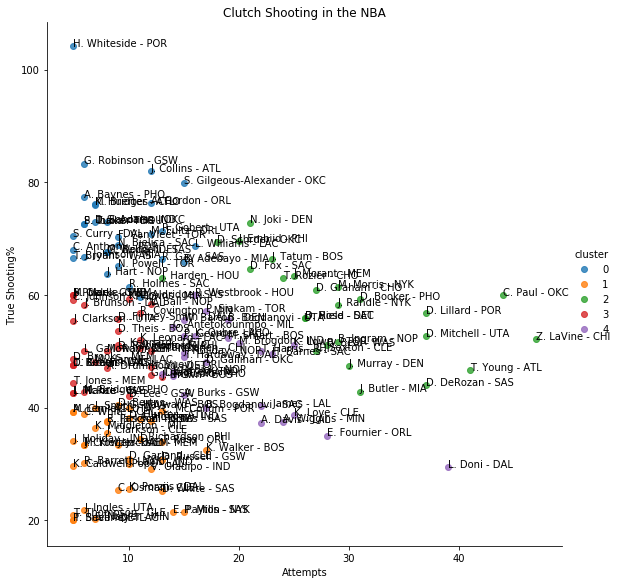

In [334]:
%matplotlib qt
ax = sns.lmplot(x="Clutch Attempts", y="TS%", data=combined_df, hue="cluster", height = 8, fit_reg=False)
ax.set(xlabel='Attempts', ylabel='True Shooting%', title="Clutch Shooting in the NBA")
for i, txt in enumerate(combined_df['Player']):
    plt.annotate(txt, (combined_df['Clutch Attempts'][i], combined_df['TS%'][i]))

In [230]:
#cluster_0['Player'].unique()

In [335]:
print("Number of players in cluster 0:", len(cluster_0.Player.unique()))
print("Culster 0 Winning%:", cluster_0['W-L%'].mean())

print("Number of players in cluster 1:", len(cluster_1.Player.unique()))
print("Culster 1 Winning%:", cluster_1['W-L%'].mean())

print("Number of players in cluster 2:", len(cluster_2.Player.unique()))
print("Culster 2 Winning%:", cluster_2['W-L%'].mean())

print("Number of players in cluster 3:", len(cluster_3.Player.unique()))
print("Culster 3 Winning%:", cluster_3['W-L%'].mean())

print("Number of players in cluster 4:", len(cluster_4.Player.unique()))
print("Culster 4 Winning%:", cluster_4['W-L%'].mean())


Number of players in cluster 0: 29
Culster 0 Winning%: 0.499448275862069
Number of players in cluster 1: 37
Culster 1 Winning%: 0.4629189189189189
Number of players in cluster 2: 25
Culster 2 Winning%: 0.47071999999999997
Number of players in cluster 3: 32
Culster 3 Winning%: 0.45896875000000004
Number of players in cluster 4: 26
Culster 4 Winning%: 0.5596153846153846


In [336]:
#Garbage Time is defined as less than 4 minutes left and the score not is within 15 points
gar_df = fourth_quarter_df[fourth_quarter_df['SecLeft'] <= 240]
garbage_df = gar_df[abs(gar_df['AwayScore'] - gar_df['HomeScore']) >= 15]
garbage_df = garbage_df[garbage_df['Shooter'].notna()]
#Garbage Free Throws 
garbageFT_df = gar_df[gar_df['FreeThrowShooter'].notna()]
garbageFT_df.columns

Index(['URL', 'GameType', 'Location', 'Date', 'Time', 'WinningTeam', 'Quarter',
       'SecLeft', 'AwayTeam', 'AwayPlay', 'AwayScore', 'HomeTeam', 'HomePlay',
       'HomeScore', 'Shooter', 'ShotType', 'ShotOutcome', 'ShotDist',
       'Assister', 'Blocker', 'FoulType', 'Fouler', 'Fouled', 'Rebounder',
       'ReboundType', 'ViolationPlayer', 'ViolationType', 'TimeoutTeam',
       'FreeThrowShooter', 'FreeThrowOutcome', 'FreeThrowNum', 'EnterGame',
       'LeaveGame', 'TurnoverPlayer', 'TurnoverType', 'TurnoverCause',
       'TurnoverCauser', 'JumpballAwayPlayer', 'JumpballHomePlayer',
       'JumpballPoss'],
      dtype='object')

In [337]:
shooters = []
for i in garbage_df['Shooter'].unique():
    shooters.append(i)
for i in garbageFT_df['FreeThrowShooter'].unique():
    if i in shooters:
        next
    else:
        shooters.append(i)
    
#Creating Clean DataFrame with Values of Interest for Each Clutch Shooter
    
clean_df = pd.DataFrame([], columns = ['Player','Team', 'Points',
                                       'Garbage Attempts',
                                       'Garbage FT Attempts',
                                       'Makes', 'Misses', 
                                       'FT Misses', 'Shot%', 'TS%', 'Shot Distance'])

for person in shooters:
    person_df = garbage_df[garbage_df['Shooter'] == person]
    personFT_df = garbageFT_df[garbageFT_df['FreeThrowShooter'] == person]
    
    team = person[-3:]
    
    
    try:
        make = int(person_df['ShotOutcome'].value_counts()['make'])
    except:
        make = 0
    try:
        miss = int(person_df['ShotOutcome'].value_counts()['miss'])
    except:
        miss = 0
        
    try:
        FTmake = int(personFT_df['FreeThrowOutcome'].value_counts()['make'])
    except:
        FTmake = 0
    try:
        FTmiss = int(personFT_df['FreeThrowOutcome'].value_counts()['miss'])
    except:
        FTmiss = 0    
        
    FTA = FTmake + FTmiss    
    FGA = make + miss
    pts = make*2 + FTmake
    try:
        dist = float(person_df['ShotDist'].mean())
    except:
        dist = 0
    if FGA != 0:
        shotp = (make/FGA) * 100
    else:
        shotp = 0
    TSA = FGA + 0.44 * FTA
    if TSA != 0:
        TSp = pts/(2*TSA) *100
    else:
        TSp = 0
    clean_df = clean_df.append({'Player': person,
                                'Team':team,
                                'Points':pts,
                                'Garbage Attempts':FGA,
                                'Garbage FT Attempts':FTA,
                                'Makes':make,
                                'FT Makes': FTmake,
                                'Misses':miss,
                                'FT Misses':FTmiss,
                                'Shot%':shotp,
                                'TS%':TSp,
                                'Shot Distance':dist},
                                 ignore_index = True)    


#Have Garbage Shooting From 529 NBA Players
clean_df = clean_df[clean_df['Garbage Attempts'] > 4]
clean_df.shape

(333, 12)

In [338]:
combined_df = clean_df.merge(team_2020_df[['Team', 'W-L%']], how="inner", on="Team")
#combined_df.drop(columns =['index'])
combined_df.head()

,Player,Team,Points,Garbage Attempts,Garbage FT Attempts,Makes,Misses,FT Misses,Shot%,TS%,Shot Distance,FT Makes,W-L%
0,D. Garland - CLE,CLE,33,27,17,10,17,4,37.037037,47.853828,16.518519,13.0,0.292
1,T. Thompson - CLE,CLE,20,10,14,6,4,6,60.000000,61.881188,7.200000,8.0,0.292
2,C. Sexton - CLE,CLE,59,17,49,11,6,12,64.705882,76.504149,13.176471,37.0,0.292
3,K. Porter - CLE,CLE,27,25,15,8,17,4,32.000000,42.721519,15.560000,11.0,0.292
4,M. Dellavedova - CLE,CLE,9,5,7,1,4,0,20.000000,55.693069,20.400000,7.0,0.292


In [339]:
k_means = KMeans(n_clusters=4)
cluster_source = combined_df.loc[:,['Garbage Attempts','Points', 'Shot Distance', 'TS%', 'W-L%']]
kmeans = k_means.fit(cluster_source)
combined_df['cluster'] = kmeans.labels_
cluster_0 = combined_df[combined_df["cluster"] == 0]
cluster_1 = combined_df[combined_df["cluster"] == 1]
cluster_2 = combined_df[combined_df["cluster"] == 2]
cluster_3 = combined_df[combined_df["cluster"] == 3]
#cluster_4 = combined_df[combined_df["cluster"] == 4]

In [340]:
%matplotlib qt
ax = sns.lmplot(x="Garbage Attempts", y="TS%", data=combined_df, hue="cluster", height=12, fit_reg=False)
ax.set(xlabel='Attempts', ylabel='True Shooting%', title="Garbage Time Shooting in the NBA")
for i, txt in enumerate(combined_df['Player']):
    plt.annotate(txt, (combined_df['Garbage Attempts'][i], combined_df['TS%'][i]))

In [342]:
print("Number of players in cluster 0:", len(cluster_0.Player.unique()))
print("Culster 0 Winning%:", cluster_0['W-L%'].mean())

print("Number of players in cluster 1:", len(cluster_1.Player.unique()))
print("Culster 1 Winning%:", cluster_1['W-L%'].mean())

print("Number of players in cluster 2:", len(cluster_2.Player.unique()))
print("Culster 2 Winning%:", cluster_2['W-L%'].mean())

print("Number of players in cluster 3:", len(cluster_3.Player.unique()))
print("Culster 3 Winning%:", cluster_3['W-L%'].mean())

# print("Number of players in cluster 4:", len(cluster_4.Player.unique()))
# print("Culster 4 Winning%:", cluster_4['W-L%'].mean())

Number of players in cluster 0: 53
Culster 0 Winning%: 0.5172264150943396
Number of players in cluster 1: 35
Culster 1 Winning%: 0.5297428571428572
Number of players in cluster 2: 119
Culster 2 Winning%: 0.4905966386554624
Number of players in cluster 3: 118
Culster 3 Winning%: 0.4814491525423732
